1. Upload zip file signs.zip to 'My Drive' 
2. Mount your drive using code below. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 3. Unzip the file:



In [0]:
import os
os.chdir("/content/drive/My Drive/Project/Signs/")
#!unzip signs.zip

In [3]:
!ls

__MACOSX  signs  signs.zip


You just unziped your folder. Take a look at the structure, and pictures

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import warnings
warnings.filterwarnings("ignore")

Define transforms, rezise, rotate slightly, preform horizontal flip

In [0]:
data_dir = 'signs'

batch_size = 32
# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.Resize([255,255]),
                                       transforms.RandomHorizontalFlip(0.5),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5],
                                                           [0.5, 0.5, 0.5])])

val_transforms = transforms.Compose([transforms.Resize([255,255]),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5],
                                                           [0.5, 0.5, 0.5])])
test_transforms = transforms.Compose([transforms.Resize([255,255]),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5],
                                                           [0.5, 0.5, 0.5])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
valid_data = datasets.ImageFolder(data_dir + '/valid', transform=test_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=4)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=4)

classes = dict(enumerate(trainloader.dataset.classes))


________________________________

In [6]:
classes

{0: 'dog',
 1: 'dragon',
 2: 'goat',
 3: 'horse',
 4: 'monkey',
 5: 'ox',
 6: 'pig',
 7: 'rabbit',
 8: 'ratt',
 9: 'rooster',
 10: 'snake',
 11: 'tiger'}

Create Models

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet34(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(512, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 12),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Train the Model

In [9]:
running_loss = 0.0
running_val_loss = 0.0
running_losses = []
running_val_losses = []

for epoch in range(7):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        i_, l_ = data
        inputs = i_.to(device)
        labels = l_.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        if i % 100 == 99:    # print every 100 mini-batches
            model.eval()

            for i_v, data_v in enumerate(validloader):
              i_, l_ = data_v
              inputs = i_.to(device)
              labels = l_.to(device)
              outputs = model(inputs)
              loss = criterion(outputs, labels)
              running_val_loss += loss.item()

            print('[%d, %5d]\ttrain loss: %.3f\tval loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100, running_val_loss / len(validloader) ))
            running_losses.append(running_loss / 100)
            running_val_losses.append(running_val_loss / len(validloader))
            running_loss = 0.0
            running_val_loss = 0.0
            model.train()

print('Finished Training')

[1,   100]	train loss: 0.741	val loss: 0.358
[1,   200]	train loss: 0.467	val loss: 0.293
[2,   100]	train loss: 0.380	val loss: 0.360
[2,   200]	train loss: 0.361	val loss: 0.284
[3,   100]	train loss: 0.327	val loss: 0.339
[3,   200]	train loss: 0.357	val loss: 0.277
[4,   100]	train loss: 0.305	val loss: 0.252
[4,   200]	train loss: 0.296	val loss: 0.236
[5,   100]	train loss: 0.273	val loss: 0.233
[5,   200]	train loss: 0.292	val loss: 0.236
[6,   100]	train loss: 0.286	val loss: 0.257
[6,   200]	train loss: 0.256	val loss: 0.205
[7,   100]	train loss: 0.259	val loss: 0.261
[7,   200]	train loss: 0.267	val loss: 0.238
Finished Training


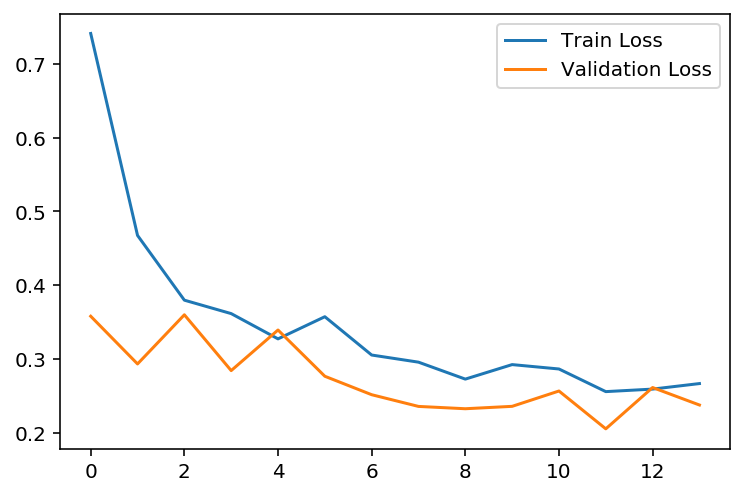

In [15]:
plt.plot(range(len(running_losses)), running_losses , label="Train Loss")
plt.plot(range(len(running_val_losses)), running_val_losses, label="Validation Loss")
plt.legend()

Test the model

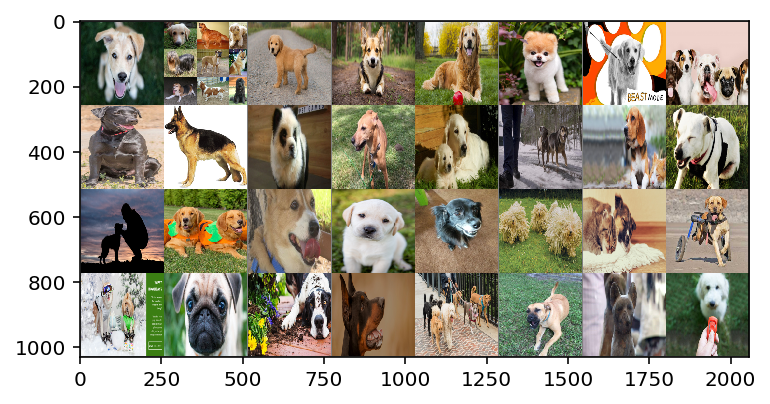

KeyError: ignored

In [21]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
state = {
    'epoch': 7,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict()
}
torch.save(model.state_dict(), "modeloptim_resnet34_20200111.pt")

# # load for later
# model = models.resnet34(pretrained=True)
# for param in model.parameters():
#     param.requires_grad = False
# model.fc = nn.Sequential(nn.Linear(512, 512),
#                                  nn.ReLU(),
#                                  nn.Dropout(0.2),
#                                  nn.Linear(512, 12),
#                                  nn.LogSoftmax(dim=1))
# model.load_state_dict(state['state_dict'])
# optimizer.load_state_dict(state['optimizer'])
